In [179]:
import numpy

from typing import Iterator, Tuple

(O'Brien, 2014)

$E_i \in \mathbb{R}$ is the elastic energy for node $i$:

$$
E_i
= \sum^N_{j = 1} \frac{K_{ij}}{2} (\mathbf{u}_{ij} \cdot \mathbf{n}_{ij})^2
+ \sum^{N^2}_{jk} \frac{c_{ijk}}{2} \left( \cos \theta_{jik} - \frac{1}{\sqrt{2}} \right)^2
$$

where

* $K_{ij} \in \mathbb{R}$ is the elastic spring constant
* $N = 8$ is the number of neighbors (for the 2D lattice)
* $\mathbf{u}_{ij} = \mathbf{u}_i - \mathbf{u}_j \in \mathbb{R}^2$ is the displacement
* $\mathbf{x}_{ij} = \mathbf{x}_i - \mathbf{x}_j \in \mathbb{R}^2$ is the vector connecting nodes $i$ and $j$ on the undistorted lattice
* $\mathbf{n}_{ij} = \frac{\mathbf{x}_{ij}}{|\mathbf{x}_{ij}|} \in \mathbb{R}^2$
* $c_{jik} \in \mathbb{R}$ is the bond-bending constant
* $\theta_{jik} \in \mathbb{R}$ is the angle between $j$ and $k$ with $i$ as the apex

The first sum is over all the neighbors $j$ of $i$.
The second sum is over *all* pairs of neighbors $jk$ of $i$.

In [309]:
class ELM:
    n_rows: int
    n_cols: int
    displacement: numpy.ndarray
    velocity: numpy.ndarray
    force: numpy.ndarray

    # K
    elastic_spring_constant: float
    # c
    bond_bending_constant: float
    
    def __init__(self, n_rows: int, n_cols: int):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.displacement = numpy.zeros((n_rows, n_cols, 2))
        self.velocity = numpy.zeros((n_rows, n_cols, 2))
        self.force = numpy.zeros((n_rows, n_cols, 2))

        self.elastic_spring_constant = 1.0
        self.bond_bending_constant = 1.0

    # u_i(t)
    def get_displacement(self, row: int, col: int) -> numpy.ndarray:
        return self.displacement[row, col, :]

    def set_displacement(self, row: int, col: int, displacement: numpy.ndarray) -> None:
        self.displacement[row, col, :] = displacement

    # x_i(t)
    def get_lattice_position(self, row: int, col: int) -> numpy.ndarray:
        return numpy.array([col, row], dtype=float)

    # v_i(t)
    def get_velocity(self, row: int, col: int) -> numpy.ndarray:
        return self.velocity[row, col, :]

    # F_i(t)
    def get_force(self, row: int, col: int) -> numpy.ndarray:
        return self.force[row, col, :]

    def set_force(self, row: int, col: int, force: numpy.ndarray) -> None:
        self.force[row, col, :] = force

(O'Brien, 2008)

The force acting on node $i$ is given by

$$
\mathbf{F}_i = \sum^N_j \mathbf{F}_{ij}
$$

Where $N = 8$ (for the 2D case) is the number of neighbors $j$.
The force $\mathbf{F}_{ij}$ on node $i$ from node $j$ is given by

$$
\mathbf{F}_{ij} = K_{ij} (\mathbf{u}_{ij} \cdot \mathbf{x}_{ij}) + \frac{c \mathbf{u}_{ij}}{|\mathbf{x}_{ij}|^2}
$$

where

* $K_{ij}$ is the elastic spring constant
* $\mathbf{u}_{ij} = \mathbf{u}_i - \mathbf{u}_j \in \mathbb{R}^2$ is the displacement
* $\mathbf{x}_{ij} = \mathbf{x}_i - \mathbf{x}_j \in \mathbb{R}^2$ is the vector connecting nodes $i$ and $j$ on the undistorted lattice
* $c \in \mathbb{R}$ is the bond-bending constant

The Lamé constants are given by

$\lambda_\text{2D} = K - \frac{c}{\Delta x^2}$

and

$\mu_\text{2D} = K + \frac{c}{\Delta x^2}$

where $\Delta x$ is the lattice grid spacing.

In [310]:
def neighbors(row: int, col: int) -> Iterator[Tuple[float, int, int]]:
    for row_offset in [-1, 0, 1]:
        for col_offset in [-1, 0, 1]:
            if row_offset == 0 and col_offset == 0:
                continue
            else:
                k = 1.0 if row_offset == 0 or col_offset == 0 else 2.0
                yield (k, row + row_offset, col + col_offset)

def calculate_force(elm: ELM, row: int, col: int) -> numpy.ndarray:
    K = elm.elastic_spring_constant
    c = elm.bond_bending_constant

    total = numpy.array([0.0, 0.0])
    for _, nb_row, nb_col in neighbors(row, col):
        u = elm.get_displacement(row, col) - elm.get_displacement(nb_row, nb_col)
        x = elm.get_lattice_position(row, col) - elm.get_lattice_position(nb_row, nb_col)

        # print((k, nb_row, nb_col))
        
        total -= K * numpy.dot(u, x) + (c * u) / numpy.linalg.norm(x) ** 2

    return total

e = ELM(20, 20)
for row in range(1, e.n_rows - 1):
    e.set_displacement(row, 2, numpy.array([0.5, 0.0]))
calculate_force(e, 2, 2)

array([-2.,  0.])

(2.0, 1, 1)
(1.0, 1, 2)
(2.0, 1, 3)
(1.0, 2, 1)
(1.0, 2, 3)
(2.0, 3, 1)
(1.0, 3, 2)
(2.0, 3, 3)


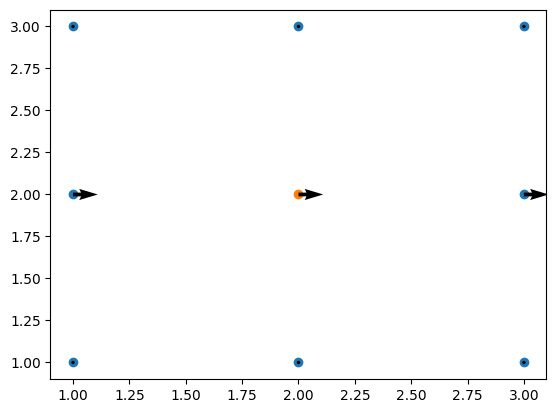

In [311]:
nbs = numpy.array([(ro, co, e.get_displacement(ro, co)[0], e.get_displacement(ro, co)[1]) for (k, ro, co) in neighbors(2, 2)])

plt.scatter(nbs[:, 0], nbs[:, 1])
plt.scatter([2], [2])
plt.quiver(nbs[:, 0], nbs[:, 1], nbs[:, 2], nbs[:, 3], scale=10)
plt.quiver([2], [2], e.get_displacement(2, 2)[0], e.get_displacement(2, 2)[1], scale=10)

for x in neighbors(2, 2):
    print(x)

A [velocity Verlet integration](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet) scheme is used to solve the system.

Our initial configuration defines for each of the $M$ nodes $i$:

* $\mathbf{u}_i(t_0) \in \mathbb{R}^M \times 2$: Displacement
* $\mathbf{v}_i(t_0) \in \mathbb{R}^M \times 2$: Velocity

To calculate a time step, do for every node $i$:

* Calculate the displacement $\mathbf{u}_i(t + \Delta t) = \mathbf{u}_i(t) + \mathbf{v}_i(t) \Delta t + \frac{1}{2} \mathbf{F}_i(t) \Delta t^2$
* Calculate $\mathbf{F}_i(t + \Delta t)$ using $\mathbf{u}_i(t + \Delta t)$
* Calculate $\mathbf{v}_i(t + \Delta t) = \mathbf{v}_i(t) + \frac{1}{2} (\mathbf{F}_i(t) + \mathbf{F}_i(t + \Delta t)) \Delta t$

In [312]:
def velocity_verlet_step(elm: ELM, delta_t: float) -> ELM:
    new_elm = ELM(elm.n_rows, elm.n_cols)

    new_elm.displacement = elm.displacement + elm.velocity * delta_t + 0.5 * elm.force * delta_t * delta_t
    for row in range(1, elm.n_rows - 1):
        for col in range(1, elm.n_cols - 1):
            new_elm.set_force(row, col, calculate_force(new_elm, row, col))
    new_elm.velocity = elm.velocity + 0.5 * (elm.force + new_elm.force) * delta_t

    return new_elm

In [313]:
es = [e]
for _ in range(1000):
    es.append(velocity_verlet_step(es[-1], 0.002))

In [314]:
import matplotlib.pyplot as plt
%matplotlib inline

In [315]:
from ipywidgets import interact

In [316]:
x, y = numpy.meshgrid(
    numpy.linspace(0, e.n_rows - 1, e.n_rows, dtype=int),
    numpy.linspace(0, e.n_cols - 1, e.n_cols, dtype=int)
)

def do_plot(i: int) -> None:
    plt.scatter(
        x + es[i].displacement[:, :, 0],
        y + es[i].displacement[:, :, 1]
    )
    plt.quiver(
        x + es[i].displacement[:, :, 0],
        y + es[i].displacement[:, :, 1],
        es[i].force[:, :, 0],
        es[i].force[:, :, 1],
        scale = 100
    )
    plt.show()

interact(do_plot, i = (0, len(es) - 1, 1))

interactive(children=(IntSlider(value=500, description='i', max=1000), Output()), _dom_classes=('widget-intera…

<function __main__.do_plot(i: int) -> None>